In [53]:
import pandas as pd
import numpy as np
import os
import gget
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import sys
import itertools
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import pyranges as pr
import gget
import scipy

import utils as ut

In [2]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
xyPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"
xy = pd.read_csv(xyPath)

macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
]

print()

keys = ['ND', 'HFD8', 'HFD14']

rna = {}
labels = {}

for key in keys:
    print(f"{key}...")
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    
    lf = lf.drop_duplicates(subset='cellId')
    lf = lf[lf['cellType'].isin(macTypes)]
    
    lf = pd.merge(lf, xy[['x', 'y', 'cellId', 'colors']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    

    cellIds = lf['cellId'].to_list()
    labels[key] = lf
    
    rnaPath = f"{cardDir}{key}_macrophage_rna.csv"
    rf = pd.read_csv(rnaPath)
    rf = rf.T
    new_header = rf.iloc[0] 
    rf = rf[1:] 
    rf.columns = new_header 
    rf.index.names = ['cellId']

    rf = rf[rf.index.isin(cellIds)]
    print(f"{key=} {lf.shape=} {rf.shape}")
    
    rf = ut.normalize(rf, 1e6)
    rna[key] = rf
    

print('done')


ND...
key='ND' lf.shape=(360, 6) (359, 31053)
HFD8...
key='HFD8' lf.shape=(2194, 6) (2188, 31053)
HFD14...
key='HFD14' lf.shape=(3893, 6) (3884, 31053)
done


In [3]:
# merge all expression
rdf = []
for key in keys:
    rf = rna[key].copy()
    rf.index = rf.index + "_" + key
    rdf.append(rf)

rdf = pd.concat(rdf)
print(f"{rdf.shape=}")
rdf.head()

rdf.shape=(6431, 31053)


Unnamed: 0,XKR4,GM1992,GM37381,RP1,SOX17,GM37323,MRPL15,LYPLA1,GM37988,TCEA1,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,VMN2R122,CAAA01147332.1
cellId,,,,,,,,,,,,,,,,,,,,,
AAAGAACGTCTACAGT.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,365.89828,...,0.0,0.0,0.0,0.0,0.0,0.0,365.89828,365.89828,0.0,0.0
AAAGAACTCCTCGCAT.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1103.509159,220.701832,0.0,0.0
AAAGGGCGTTAGGGTG.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,111.994624,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111.994624
AACAAAGCACCGGCTA.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,85.697146,0.0,0.0,0.0
AACAAAGGTTCACGAT.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,331.619964,0.0,331.619964,...,0.0,0.0,0.0,0.0,0.0,0.0,331.619964,331.619964,0.0,0.0


In [4]:
""" Build the reference dataframe """
ref = []
for key in keys:
    lf = labels[key]
    ref.append(lf)

ref = pd.concat(ref, ignore_index=True)
ref = ref.rename(columns={'sampleInfo' : 'key'})
ref['id'] = ref['cellId'] + "_" + ref['key']
print(f"{ref.shape=}")
ref.head()

ref.shape=(6447, 7)


,cellId,cellType,key,x,y,colors,id
0,AAAGAACGTCTACAGT.1,Mac1,ND,3.089298,-1.726030,#fdbf6f,AAAGAACGTCTACAGT.1_ND
1,AAAGAACTCCTCGCAT.1,Mac1,ND,3.614130,-1.571004,#fdbf6f,AAAGAACTCCTCGCAT.1_ND
2,AAAGGGCGTTAGGGTG.1,Mac3,ND,3.086352,6.166065,#fdbf6f,AAAGGGCGTTAGGGTG.1_ND
3,AACAAAGCACCGGCTA.1,Mac3,ND,4.344001,5.801922,#fdbf6f,AACAAAGCACCGGCTA.1_ND
4,AACAAAGGTTCACGAT.1,Mac1,ND,0.130051,-1.583494,#fdbf6f,AACAAAGGTTCACGAT.1_ND


In [5]:
""" Load the TF data """

fpath = "/nfs/turbo/umms-indikar/shared/projects/chan_zuckerberg_prelim/data/uniprot/mus_musculus.tsv"

df = pd.read_csv(fpath, sep='\t')
print(f"{df.shape=}")
print()
print(df.columns)

geneMap = dict(zip(df['From'], df['Entry Name'].str.replace("_MOUSE", "")))
df.head()

df.shape=(841, 21)

Index(['From', 'Entry', 'Reviewed', 'Entry Name', 'Protein names',
       'Gene Names', 'Organism', 'Length', 'Alternative products (isoforms)',
       'Binding site', 'Active site', 'Activity regulation', 'Function [CC]',
       'Pathway', 'Cofactor', 'DNA binding', 'Interacts with',
       'Tissue specificity', 'Gene Ontology (biological process)',
       'Involvement in disease', 'Motif'],
      dtype='object')


,From,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Alternative products (isoforms),Binding site,...,Activity regulation,Function [CC],Pathway,Cofactor,DNA binding,Interacts with,Tissue specificity,Gene Ontology (biological process),Involvement in disease,Motif
0,Q61221,Q61221,reviewed,HIF1A_MOUSE,Hypoxia-inducible factor 1-alpha (HIF-1-alpha)...,Hif1a,Mus musculus (Mouse),836,ALTERNATIVE PRODUCTS: Event=Alternative splic...,NaN,...,ACTIVITY REGULATION: Induced by reactive oxyge...,FUNCTION: Functions as a master transcriptiona...,NaN,NaN,NaN,P35583; Q8BIF2; P51450-2; Q09472; P40337; P537...,TISSUE SPECIFICITY: Ubiquitous.,angiogenesis [GO:0001525]; apoptotic process [...,NaN,"MOTIF 728..731; /note=""Nuclear localization si..."
1,Q9QX98,Q9QX98,reviewed,PTF1A_MOUSE,Pancreas transcription factor 1 subunit alpha ...,Ptf1a Ptf1p48,Mus musculus (Mouse),324,ALTERNATIVE PRODUCTS:,NaN,...,NaN,FUNCTION: Transcription factor implicated in t...,NaN,NaN,NaN,NaN,TISSUE SPECIFICITY: Expressed in precursors of...,amacrine cell differentiation [GO:0035881]; ce...,NaN,NaN
2,P15307,P15307,reviewed,REL_MOUSE,Proto-oncogene c-Rel,Rel,Mus musculus (Mouse),587,ALTERNATIVE PRODUCTS:,NaN,...,NaN,FUNCTION: Proto-oncogene that may play a role ...,NaN,NaN,NaN,Q60778,NaN,I-kappaB kinase/NF-kappaB signaling [GO:000724...,NaN,"MOTIF 291..296; /note=""Nuclear localization si..."
3,Q61656,Q61656,reviewed,DDX5_MOUSE,Probable ATP-dependent RNA helicase DDX5 (EC 3...,Ddx5 Tnz2,Mus musculus (Mouse),614,ALTERNATIVE PRODUCTS:,"BINDING 114..116; /ligand=""ATP""; /ligand_id=""C...",...,NaN,FUNCTION: Involved in the alternative regulati...,NaN,NaN,NaN,Q63014,NaN,"alternative mRNA splicing, via spliceosome [GO...",NaN,"MOTIF 94..122; /note=""Q motif""; MOTIF 248..251..."
4,Q9R207,Q9R207,reviewed,NBN_MOUSE,Nibrin (Cell cycle regulatory protein p95) (Ni...,Nbn Nbs1,Mus musculus (Mouse),751,ALTERNATIVE PRODUCTS:,NaN,...,NaN,FUNCTION: Component of the MRE11-RAD50-NBN (MR...,NaN,NaN,NaN,Q61216,TISSUE SPECIFICITY: High expression in the liv...,blastocyst growth [GO:0001832]; DNA damage che...,NaN,"MOTIF 461..467; /note=""Nuclear localization si..."


In [12]:
# load GTF for protien coding genes

gtfPath = "/nfs/turbo/umms-indikar/shared/projects/chan_zuckerberg_prelim/data/GTF/Mus_musculus.GRCm39.109.gtf.gz"

gr = pr.read_gtf(gtfPath)
gf = gr.as_df()
print(f"{gf.shape=}")


kdf = gf[gf['Feature'] == 'gene']
kdf = kdf[kdf['gene_biotype'] == 'protein_coding']

pt_genes = kdf['gene_name'].to_list()

pt_genes[:10]

gf.shape=(1901238, 26)


['Pcmtd1',
 'Cdh7',
 'Exo1',
 'Becn2',
 'Gmppa',
 'Asic4',
 'Cntnap5a',
 'Gm19965',
 'Rrs1',
 'Gm29106']

In [67]:
""" get all TF targets """

rootdir = "/nfs/turbo/umms-indikar/shared/projects/chan_zuckerberg_prelim/data/GTRD/mus_musculus/genes promoter[-1000,+100]/"
t = 1 # threshold for the minimum number of number of GTRD meta-clusters matched to gene/transcript

tdf = []

for geneFile in os.listdir(rootdir):
    fullPath = f"{rootdir}{geneFile}"
    geneId = geneFile.replace(".txt", '')
    geneName = geneMap[geneId].upper()

    if not geneName in rdf.columns:
        continue

    gdf = pd.read_csv(fullPath, sep='\t')

    gdf = gdf[gdf['SiteCount'] > t]
    gdf = gdf[gdf['Gene symbol'].isin(pt_genes)] # must be protien coding
    gdf = gdf.drop_duplicates(subset='Gene symbol')
    gdf['Gene symbol'] = gdf['Gene symbol'].str.upper()
    gdf = gdf[gdf['Gene symbol'].isin(rdf.columns)] # must be included in data columns
    gdf['TF'] = geneName
    # print(gdf.shape)
    # print(gdf.head())

    tdf.append(gdf)


tdf = pd.concat(tdf)
tdf = tdf.rename(columns={'Gene symbol' : 'gene'})
print(f"{tdf.shape=}")
print(f"{tdf['TF'].nunique()=}")
print(f"{tdf['gene'].nunique()=}")
tdf.head()

tdf.shape=(1491042, 4)
tdf['TF'].nunique()=497
tdf['gene'].nunique()=17771


,ID,gene,SiteCount,TF
136,ENSMUSG00000027962,VCAM1,2,TLX1
199,ENSMUSG00000033855,STON1,2,TLX1
272,ENSMUSG00000046139,PATL1,2,TLX1
0,ENSMUSG00000000001,GNAI3,3,ISX
1,ENSMUSG00000000028,CDC45,5,ISX


In [68]:
geneList = list(set(tdf['gene'].to_list() + tdf['TF'].to_list()))
print(len(geneList))

17774


In [69]:
# get differential expression of the markers
deg = []

for mtype in sorted(ref['cellType'].unique()):
    print(f"working {mtype}...")
    cellIds = ref[ref['cellType'] == mtype]['id'].to_list()
    
    mask = rdf.index.isin(cellIds)
    inGroup = rdf[mask]
    outGroup = rdf[~mask]

    """DEG for highly variable genes"""
    for g in geneList:
        score, pval = scipy.stats.ranksums(inGroup[g], outGroup[g],
                                           alternative='two-sided')

        lfc = np.log2(inGroup[g].mean()+1) - np.log2(outGroup[g].mean()+1)

        row = {
            'gene' : g,
            "cellType" : mtype,
            'score' : score,
            'pval' : pval,
            'log2foldchange' : lfc,
            'meanP1' : inGroup[g].mean(),
            'propP1' : inGroup[g].astype(bool).sum() / len(inGroup),
            'meanP2' : outGroup[g].mean(),
            'propP2' : outGroup[g].astype(bool).sum() / len(outGroup),
        }
        deg.append(row)
        
deg = pd.DataFrame(deg)
deg.head()

working Mac1...
working Mac2...
working Mac3...
working Mac4...
working Mac5...


,gene,cellType,score,pval,log2foldchange,meanP1,propP1,meanP2,propP2
0,SYMPK,Mac1,-3.079716,2.071981e-03,0.236781,37.198229,0.168224,31.416428,0.249086
1,CACNA2D4,Mac1,0.439895,6.600132e-01,1.494325,2.707438,0.011423,0.315943,0.002560
2,GOT2,Mac1,-6.044611,1.497706e-09,-0.305511,38.027329,0.187954,47.232155,0.333760
3,DLX4,Mac1,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
4,CSTA1,Mac1,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000


In [70]:
alpha = 0.05
ntests = tdf['TF'].nunique()
alphaHat = 1 - ((1-alpha) ** (1/ntests))
print(f"{alpha=} {ntests=} {alphaHat}")

sig = deg[deg['log2foldchange'].abs() > 1]
sig = sig[sig['pval'] < alphaHat]
print(sig.shape)
print(sig['cellType'].value_counts())

alpha=0.05 ntests=497 0.00010320049817957866
(3306, 9)
cellType
Mac3    1221
Mac2     788
Mac1     643
Mac5     551
Mac4     103
Name: count, dtype: int64


In [77]:
# build a data structure for TF scoring

tfMap = tdf.groupby('TF')['gene'].apply(list).to_dict()
print(len(tfMap))

497


In [94]:
res = []

deg['sig'] = np.where(deg['pval'] <= alphaHat, 1, 0)

for mtype in sorted(ref['cellType'].unique()):
    mdeg = deg[deg['cellType'] == mtype]

    for TF, targets in tfMap.items():
        tfdeg = mdeg[mdeg['gene'].isin(targets)]
        row = {
            'cellType' : mtype,
            "TF" : TF,
            "nTargets" : len(tfdeg),
            'sigTargets' : tfdeg['sig'].sum(),
            'percSig' : tfdeg['sig'].sum() / len(tfdeg),
            'nUp' : tfdeg.loc[tfdeg['log2foldchange'] > 0, 'gene'].count(),
            'nDown' : tfdeg.loc[tfdeg['log2foldchange'] < 0, 'gene'].count(),
            'meanLFC_up' : tfdeg.loc[tfdeg['log2foldchange'] > 0, 'log2foldchange'].mean(),
            'meanLFC_down' : tfdeg.loc[tfdeg['log2foldchange'] < 0, 'log2foldchange'].mean(),
        }

        res.append(row)


res = pd.DataFrame(res)
res.head()

,cellType,TF,nTargets,sigTargets,percSig,nUp,nDown,meanLFC_up,meanLFC_down
0,Mac1,ABCC9,452,83,0.183628,227,194,0.410063,-0.379831
1,Mac1,AEBP2,248,22,0.088710,72,91,0.503602,-0.376167
2,Mac1,AFF3,1660,470,0.283133,846,758,0.397210,-0.380444
3,Mac1,AFF4,139,48,0.345324,57,75,0.451836,-0.428049
4,Mac1,AHR,386,99,0.256477,200,175,0.460561,-0.429028


In [101]:
res.to_csv("TF_targets.csv", index=False)

In [100]:
for mtype in res['cellType'].unique():
    pdf = res[res['cellType'] == mtype]

    pdf = pdf.sort_values(by='percSig', ascending=False)
    print(pdf.head(20))

    break

    cellType     TF  nTargets  sigTargets   percSig  nUp  nDown  meanLFC_up   
472     Mac1   TOX3         3           3  1.000000    2      1    0.442665  \
257     Mac1   MPND         1           1  1.000000    1      0    0.222848   
182     Mac1   ING1         1           1  1.000000    0      1         NaN   
242     Mac1   MBD1         1           1  1.000000    1      0    0.749595   
163     Mac1  HELLS         1           1  1.000000    0      1         NaN   
273     Mac1  MYO1C         1           1  1.000000    0      1         NaN   
281     Mac1  NCOA1         1           1  1.000000    0      1         NaN   
168     Mac1   HHEX         1           1  1.000000    0      1         NaN   
320     Mac1  PARP1         1           1  1.000000    0      1         NaN   
34      Mac1  BRWD1         1           1  1.000000    0      1         NaN   
482     Mac1   WDR5        36          23  0.638889    8     28    0.372087   
117     Mac1    FEV        14           8  0.571429 

In [102]:


# sns.scatterplot(data=res,
#                 x='meanLFC_up',
#                 y='meanLFC_down',
#                 hue='cellType',
#                 s=10)

In [76]:
pdx = sig[sig['cellType'] == 'Mac5']

# db = 'WikiPathways_2019_Mouse'
# db = 'KEGG_2019_Mouse'
db = 'ontology'

ef = gget.enrichr(pdx['gene'].to_list(), database=db)
ef = ef[ef['adj_p_val'] <= 0.01]

pd.set_option('display.max_colwidth', 200)
ef[['path_name', 'overlapping_genes']].head(30)

Thu May 25 09:37:00 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


,path_name,overlapping_genes
0,cellular response to cytokine stimulus (GO:0071345),"[CD86, CDKN1B, FLT3, F13A1, PTPRJ, ZFP36, GRAP2, PIM1, ITGAX, CD36, JAK2, JUNB, IL13RA1, CCR2, GBP7, ANXA1, IFNGR1, IL16, LIFR, FOS, DCSTAMP, IRF4, IL1B, BIRC5, GAS6, TLR2, CEBPD, CXCR4, PIK3R1, A..."
1,cytokine-mediated signaling pathway (GO:0019221),"[IFITM3, CD86, SLC27A1, CIITA, CDKN1B, FLT3, F13A1, PTPRJ, GRAP2, PIM1, ITGAX, MAP3K8, CD36, JAK2, JUNB, IL13RA1, CCR2, ANXA1, ANXA2, IFNGR1, TNFRSF18, IL16, LIFR, FOS, TRAF1, IL17RA, IRF4, IL1B, ..."
2,neutrophil mediated immunity (GO:0002446),"[KMT2E, CD63, CSTB, GMFG, FGL2, CTSZ, PTPRJ, ITGAL, AP2A2, PLAC8, LGALS3, HK3, SYNGR1, GLIPR1, CYB5R3, ALOX5, ANPEP, CREG1, ITGAX, TBC1D10C, CD36, GUSB, CTSD, CD33, CTSC, VAT1, ANXA2, PGAM1, MCEMP..."
3,neutrophil degranulation (GO:0043312),"[CD63, CSTB, GMFG, FGL2, CTSZ, PTPRJ, ITGAL, AP2A2, PLAC8, LGALS3, HK3, SYNGR1, GLIPR1, CYB5R3, ALOX5, ANPEP, CREG1, ITGAX, TBC1D10C, CD36, GUSB, CTSD, CD33, CTSC, VAT1, ANXA2, PGAM1, MCEMP1, NFKB..."
4,neutrophil activation involved in immune response (GO:0002283),"[CD63, CSTB, GMFG, FGL2, CTSZ, PTPRJ, ITGAL, AP2A2, PLAC8, LGALS3, HK3, SYNGR1, GLIPR1, CYB5R3, ALOX5, ANPEP, CREG1, ITGAX, TBC1D10C, CD36, GUSB, CTSD, CD33, CTSC, VAT1, ANXA2, PGAM1, MCEMP1, NFKB..."
5,regulation of inflammatory response (GO:0050727),"[SETD4, PTGER4, AKNA, LPL, TNFAIP3, AOAH, ETS1, SBNO2, ALOX5, CCL5, NFKBIZ, CCL3, JAK2, CCR2, ANXA1, NR1H3, IL16, KLF4, IL17RA, NFKBIA, IL1B, CD200, MGLL, TLR2, BIRC3]"
6,regulation of natural killer cell chemotaxis (GO:2000501),"[KLRK1, CCL7, CCL5, CCL4, CCL3, CCL2]"
7,eosinophil chemotaxis (GO:0048245),"[CCL24, LGALS3, CCL8, CCL7, CCL5, CCL4, CCL3, CCL2]"
8,eosinophil migration (GO:0072677),"[CCL24, LGALS3, CCL8, CCL7, CCL5, CCL4, CCL3, CCL2]"
9,inflammatory response (GO:0006954),"[PTGER4, CIITA, CXCR4, ITGAL, AIF1, CCL8, CCL7, CCL5, CCL4, CCL3, CCL2, CCR2, GGT5, CCL24, ANXA1, STAT3, FOS, NFKB1, CXCL10, IL1B, REL, ADAM8, FCGR2B, MGLL, TLR2]"


(6431, 497)

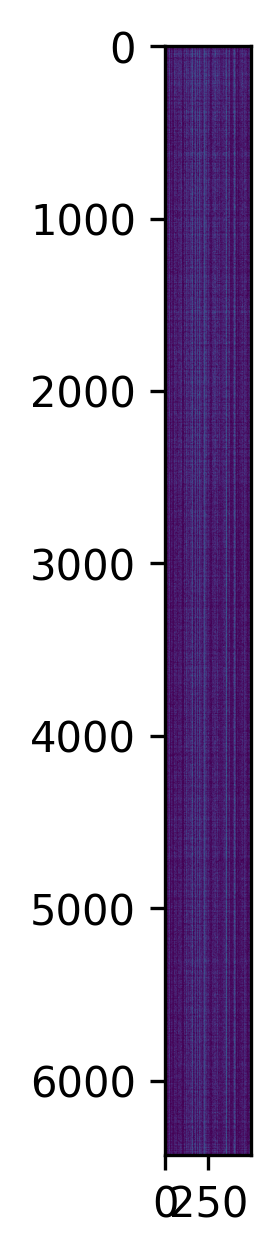

In [39]:
### first, we examine TF structure

pdf = rdf[tdf['TF'].unique()]
pdf = pdf.to_numpy().astype(float)

plt.rcParams['figure.dpi'] = 300
plt.imshow(np.log1p(pdf))

pdf.shape

In [25]:
rdf.columns[:10]

Index(['XKR4', 'GM1992', 'GM37381', 'RP1', 'SOX17', 'GM37323', 'MRPL15',
       'LYPLA1', 'GM37988', 'TCEA1'],
      dtype='object', name='Unnamed: 0')